In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman
from slsim.Observations.roman_speclite import configure_roman_filters
from slsim.Observations.roman_speclite import filter_names
import speclite.filters
import matplotlib.patches as mpatches

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs
from mejiro.instruments.roman import Roman as RomanInstrument

In [2]:
def get_zeropoint_magnitude(wavelength, response, effective_area=4.5 * 1e4):
    # effective area in cm^2

    # assert that wavelength values are evenly spaced
    assert np.allclose(np.diff(wavelength), np.diff(wavelength)[0])

    dv = np.diff(wavelength)[0]
    integral = 0
    for wl, resp in zip(wavelength, response):
        integral += (dv * (1 / wl) * resp)
    
    return 8.9 + (2.5 * np.log10(((effective_area * 1e-23) / (6.602 * 1e-27)) * integral))

In [3]:
def get_lenstronomy_zeropoint(band):
    if band in ['F087', 'F146']:
        survey_mode = 'microlensing'
    else:
        survey_mode = 'wide_area'
    lenstronomy_roman_config = Roman(band=band.upper(),
                                    psf_type='PIXEL',
                                    survey_mode=survey_mode).kwargs_single_band()
    return lenstronomy_roman_config.get('magnitude_zero_point')

In [4]:
def get_hounsell_et_al_zeropoint(band):
    ab_zeropoints = {
        'F062': 26.99,
        'F087': 26.39,
        'F106': 26.41,
        'F129': 26.35,
        'F158': 26.41,
        'F184': 25.96
    }

    return ab_zeropoints[band]

In [5]:
def get_og_filter_curve_zeropoint(band):
    configure_roman_filters()
    roman_filters = filter_names()
    roman_filters.sort()
    og_roman_filters = [speclite.filters.load_filter(f) for f in roman_filters[:8]]

    zp_dict = {(filter.name, get_zeropoint_magnitude(filter.wavelength, filter.response)) for filter in og_roman_filters}
    return dict(zp_dict)[f'Roman-{band}']

In [6]:
roman_bands = ['F062', 'F087', 'F106', 'F129', 'F158', 'F184', 'F213']

In [12]:
# TODO calculate spread/average of SCA-specific zeropoints
sca_names = [f'SCA{str(id).zfill(2)}' for id in range(1, 19)]

instrument = RomanInstrument()
mean_zeropoints = []
min_zeropoints = []
max_zeropoints = []
for band in roman_bands:
    band_zeropoints = []
    for sca in sca_names:
        band_zeropoints.append(instrument.get_zeropoint(band, sca))
    mean_zeropoints.append(np.mean(band_zeropoints))
    min_zeropoints.append(np.min(band_zeropoints))
    max_zeropoints.append(np.max(band_zeropoints))

pprint(mean_zeropoints)

uplims = np.array(max_zeropoints) - np.array(mean_zeropoints)
lolims = np.array(mean_zeropoints) - np.array(min_zeropoints)

[26.616120158162243,
 26.300467567283775,
 26.352821683704313,
 26.351312274735903,
 26.37423811453472,
 25.91058238454279,
 25.861508980685667]


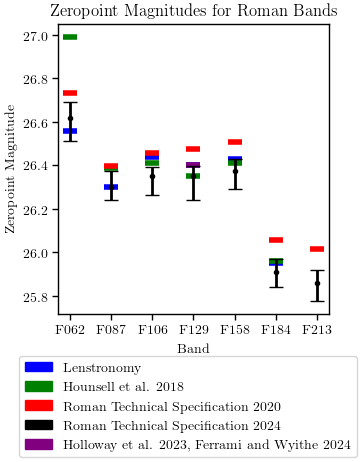

In [56]:
f = plt.figure(figsize=(3.5, 5))
plt.subplots_adjust(bottom=0.3)

for band in roman_bands:
    try:
        plt.plot(band, get_lenstronomy_zeropoint(band), '_', color='blue', ms=10, markeredgewidth=4)
    except:
        pass

    try:
        plt.plot(band, get_hounsell_et_al_zeropoint(band), '_', color='green', ms=10, markeredgewidth=4)
    except:
        pass

    try:
        plt.plot(band, get_og_filter_curve_zeropoint(band), '_', color='red', ms=10, markeredgewidth=4)
    except:
        pass

plt.plot('F129', 26.40, '_', color='purple', ms=10, markeredgewidth=4)

# plt.plot(roman_bands, mean_zeropoints, 'o', color='black')
plt.errorbar(roman_bands, mean_zeropoints, yerr=[uplims, lolims], fmt='.', color='black', capsize=5)

patch_1 = mpatches.Patch(color='blue', label='Lenstronomy')
patch_2 = mpatches.Patch(color='green', label='Hounsell et al. 2018')
patch_3 = mpatches.Patch(color='red', label='Roman Technical Specification 2020')
patch_4 = mpatches.Patch(color='black', label='Roman Technical Specification 2024')
patch_5 = mpatches.Patch(color='purple', label='Holloway et al. 2023, Ferrami and Wyithe 2024')
plt.legend(handles=[patch_1, patch_2, patch_3, patch_4, patch_5], bbox_to_anchor=(1,0), loc="lower right", bbox_transform=f.transFigure)

plt.xlabel('Band')
plt.ylabel('Zeropoint Magnitude')
plt.title('Zeropoint Magnitudes for Roman Bands')
plt.savefig(os.path.join(figure_dir, 'comparing_zeropoints.png'))
plt.show()